# Stable Voting - Running Times

Compare the running time of Simple Stable Voting and Stable Voting  from the paper [Stable Voting](https://arxiv.org/abs/2108.00542) by W. Holliday and E. Pacuit.  

In [68]:
# import the Profile class
from voting.profiles import *

# import the voting methods
from voting.voting_methods import *

from voting.generate_profiles import *
import math
import pandas as pd
from itertools import product, combinations

from functools import partial
from multiprocess import Pool, cpu_count
import pickle
import time

import copy
import matplotlib.pyplot as plt
import seaborn as sns
import os
sns.set()


In [69]:
# Simple Stable Voting is Condorcet consistent.   It is faster to skip executing the recursive algorithm 
# when there is a Condorcet winner
@vm_name("Simple Stable Voting Faster")
def simple_stable_voting_faster(profile): 
    '''First check if there is a Condorcet winner.  If so, return the Condorcet winner, otherwise 
    find the stable voting winnner using stable_voting_'''
    
    cw = profile.condorcet_winner()
    if cw is not None: 
        return [cw]
    else: 
        return simple_stable_voting_(profile, curr_cands = None, mem_sv_winners = {})[0]

# Stable Voting is Condorcet consistent.   It is faster to skip executing the recursive algorithm 
# when there is a Condorcet winner
@vm_name("Stable Voting Faster")
def stable_voting_faster(profile): 
    '''First check if there is a Condorcet winner.  If so, return the Condorcet winner, otherwise 
    find the stable voting winnner using stable_voting_'''
    
    cw = profile.condorcet_winner()
    if cw is not None: 
        return [cw]
    else: 
        return stable_voting_(profile, curr_cands = None, mem_sv_winners = {})[0]


In [71]:
from tqdm.notebook import tqdm

SKIP_TEST = True # set to false to re-run tests, but this takes a long time. 

if not SKIP_TEST: 

    import time

    data_for_df = { 
        "num_cands": [],
        "pm": [],
        "sv_avg_running_time": [],
        "sv_faster_avg_running_time": [],
        "simple_sv_avg_running_time": [],
        "max_sv_running_time": [],
        "max_simple_sv_running_time": [],
        "max_sv_faster_running_time": [],
        "mad_sv_running_time": [],
        "mad_simple_sv_running_time": [],
        "mad_sv_faster_running_time": [],
        "percent_cw": []
    }

    data_for_df2 = { 
        "num_cands": [],
        "pm": [],
        "sv_running_time": [],
        "simple_sv_running_time": [],
        "sv_faster_running_time": [],
    }

    prob_mods = [
        "IC", 
        "URN-R", 
        "MALLOWS-R",
        "MALLOWS-RELPHI-R",
        "SinglePeaked",

    ]

    ssv_cand_limit = 22
    all_num_cands = list(range(3, 29))

    num_voters = 1000
    num_trials = 1000

    cpus= cpu_count()
    print(cpus)
    pool = Pool(12)

    def record_data(num_cands, num_voters, pm, t): 

        prof = generate_profile(num_cands, num_voters, probmod=pm)
        
        s = time.time()
        sv = stable_voting(prof)
        e = time.time()
        sv_running_time = e - s
        
        s = time.time()
        stable_voting_faster(prof)
        e = time.time()
        sv_faster_running_time = e - s
        
        if num_cands < ssv_cand_limit:
            s = time.time()
            simple_stable_voting(prof)
            e = time.time()
            simple_sv_running_time = e - s
        else: 
            simple_sv_running_time = None
            
        cw = prof.condorcet_winner()

        return {
            "sv_running_time": sv_running_time,
            "sv_faster_running_time": sv_faster_running_time,
            "simple_sv_running_time": simple_sv_running_time,
            "cw": cw is not None
        }

    for pm in prob_mods:
        print(pm)
        for num_cands in all_num_cands:
            print("\t",num_cands)

            record_data_even = partial(record_data, num_cands, num_voters, pm)
            record_data_odd = partial(record_data, num_cands, num_voters + 1, pm)

            data_even = pool.map(record_data_even, range(num_trials))
            data_odd = pool.map(record_data_odd, range(num_trials))

            data = data_even + data_odd

            for d in data: 
                data_for_df2["sv_running_time"].append(d["sv_running_time"])
                data_for_df2["sv_faster_running_time"].append(d["sv_faster_running_time"])
                data_for_df2["simple_sv_running_time"].append(d["simple_sv_running_time"])
                data_for_df2["num_cands"].append(num_cands)
                data_for_df2["pm"].append(pm)

            data_for_df["num_cands"].append(num_cands)
            data_for_df["pm"].append(pm)
            data_for_df["sv_avg_running_time"].append(np.average([d["sv_running_time"] for d in data]))
            if num_cands < ssv_cand_limit:
                data_for_df["simple_sv_avg_running_time"].append(np.average([d["simple_sv_running_time"] for d in data]))
            else: 
                data_for_df["simple_sv_avg_running_time"].append(None)
                
            data_for_df["sv_faster_avg_running_time"].append(np.average([d["sv_faster_running_time"] for d in data]))

            data_for_df["max_sv_running_time"].append(max([d["sv_running_time"] for d in data]))
            if num_cands < ssv_cand_limit:
                data_for_df["max_simple_sv_running_time"].append(max([d["simple_sv_running_time"] for d in data]))
            else: 
                data_for_df["max_simple_sv_running_time"].append(None)
                
            data_for_df["max_sv_faster_running_time"].append(max([d["sv_faster_running_time"] for d in data]))

            sv_avg = np.average([d["sv_running_time"] for d in data])
            data_for_df["mad_sv_running_time"].append(np.average([math.fabs(d["sv_running_time"] - sv_avg) for d in data]))
            if num_cands < ssv_cand_limit:
                simple_sv_avg = np.average([d["sv_running_time"] for d in data])
                data_for_df["mad_simple_sv_running_time"].append(np.average([math.fabs(d["simple_sv_running_time"] - simple_sv_avg) for d in data]))
            else: 
                data_for_df["mad_simple_sv_running_time"].append(None)
                
            sv_faster_avg = np.average([d["sv_faster_running_time"] for d in data])
            data_for_df["mad_sv_faster_running_time"].append(np.average([math.fabs(d["sv_faster_running_time"] - sv_faster_avg) for d in data]))
            
            data_for_df["percent_cw"].append(len([d for d in data if d["cw"]]) / len(data))

            df = pd.DataFrame(data_for_df)
            df.to_csv(f"./python_running_times.csv", index=False)
            df2 = pd.DataFrame(data_for_df2)
            df2.to_csv(f"./python_running_times_all_times.csv", index=False)

    print("done.")
else: 
    print("Running time simulation skipped.")


Running time simulation skipped.


In [72]:
# read the pre-computed running-time data

if SKIP_TEST:
    df = pd.read_csv("./data/python_running_times.csv")
df["num_cands"] = df["num_cands"].astype(str)
df


,num_cands,pm,sv_avg_running_time,sv_faster_avg_running_time,simple_sv_avg_running_time,max_sv_running_time,max_simple_sv_running_time,max_sv_faster_running_time,mad_sv_running_time,mad_simple_sv_running_time,mad_sv_faster_running_time,percent_cw
0,3,IC,0.000181,0.000010,0.000045,0.000488,0.000125,0.000041,0.000049,0.000136,0.000004,1.0000
1,4,IC,0.000383,0.000089,0.000107,0.001046,0.000382,0.001029,0.000098,0.000277,0.000126,0.8125
2,5,IC,0.000832,0.000219,0.000204,0.013933,0.003514,0.014148,0.000220,0.000633,0.000312,0.7720
3,6,IC,0.001693,0.000766,0.000528,0.014960,0.012600,0.015697,0.000323,0.001207,0.000895,0.6010
4,7,IC,0.002986,0.001631,0.001153,0.017413,0.016013,0.015751,0.000749,0.002167,0.001737,0.5400
...,...,...,...,...,...,...,...,...,...,...,...,...
110,21,SinglePeaked,0.172274,0.000218,0.347199,0.260448,0.760831,0.000308,0.016004,0.176969,0.000019,1.0000
111,22,SinglePeaked,0.211007,0.002864,NaN,0.449736,NaN,0.453009,0.023824,NaN,0.005226,0.9910
112,23,SinglePeaked,0.251526,0.000247,NaN,0.349339,NaN,0.000370,0.027913,NaN,0.000029,1.0000
113,24,SinglePeaked,0.300464,0.005973,NaN,0.767545,NaN,0.766167,0.034503,NaN,0.011263,0.9870


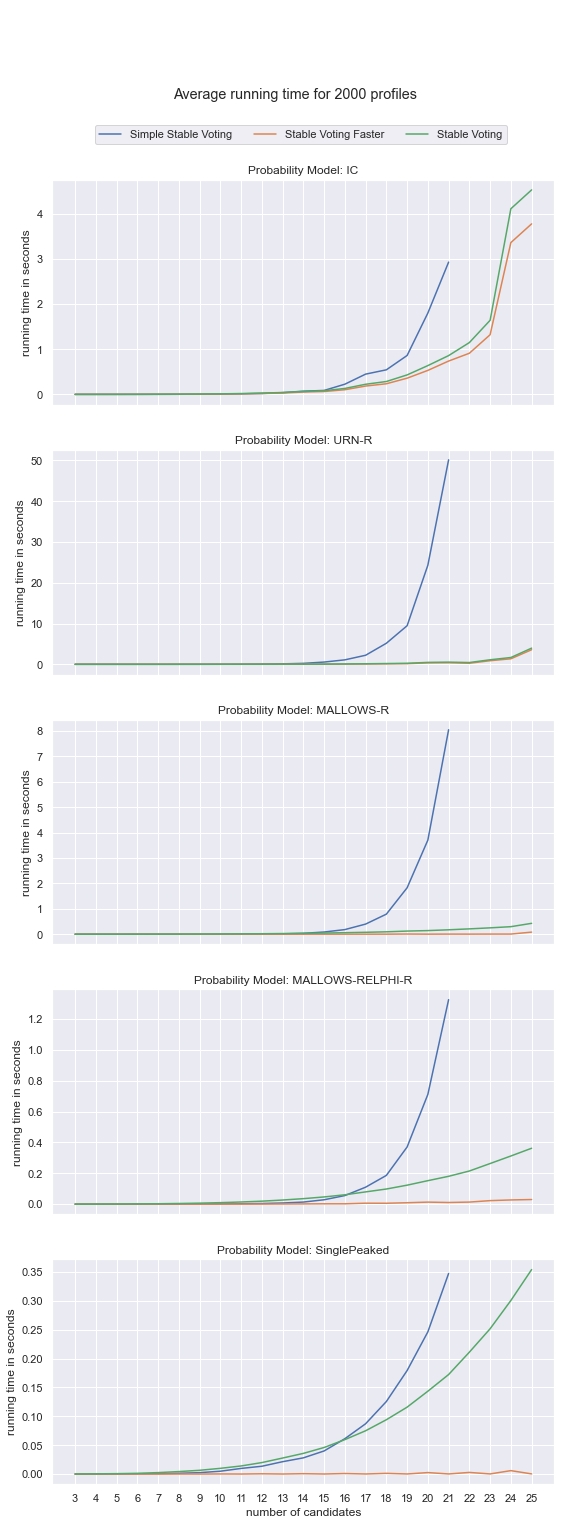

In [73]:
# running times for different probability models

pms = [
    'IC',
    'URN-R',
    'MALLOWS-R', 
    'MALLOWS-RELPHI-R', 
    'SinglePeaked'
]

fig, axs = plt.subplots(nrows=len(pms), sharex=True, figsize=(9,24))

for idx, pm in enumerate(pms): 
    ax = axs[idx]
    sns.lineplot(x="num_cands", y = "simple_sv_avg_running_time", data =df[df["pm"] == pm], ax=ax, label="Simple Stable Voting")
    sns.lineplot(x="num_cands", y = "sv_faster_avg_running_time", data =df[df["pm"] == pm], ax =ax, label="Stable Voting Faster")
    sns.lineplot(x="num_cands", y = "sv_avg_running_time", data =df[df["pm"] == pm], ax =ax, label="Stable Voting")
    ax.set_ylabel("running time in seconds")
    ax.set_xlabel("number of candidates")
    ax.set_title(f"Probability Model: {pm}")
    ax.legend().set_visible(False)
    
plt.suptitle("\n\n\n\n\nAverage running time for 2000 profiles")
plt.legend(ncol=3,bbox_to_anchor=(0.495, 6), loc='center',
                    borderaxespad=0.25)
plt.show()
#plt.savefig(f"{pm}_avg_running_times.pdf")
    


In [79]:
# data for producing boxen plots of the running times
if SKIP_TEST:
    df_all_running_times = pd.read_csv("./data/python_running_times_all_times.csv")
df_all_running_times["num_cands"] = df_all_running_times["num_cands"].astype(str)

df_all_running_times

,num_cands,pm,sv_running_time,simple_sv_running_time,sv_faster_running_time
0,3,IC,0.000409,0.000113,0.000036
1,3,IC,0.000206,0.000046,0.000014
2,3,IC,0.000207,0.000046,0.000007
3,3,IC,0.000275,0.000084,0.000028
4,3,IC,0.000110,0.000026,0.000007
...,...,...,...,...,...
229995,25,SinglePeaked,0.161518,NaN,0.000163
229996,25,SinglePeaked,0.207060,NaN,0.000167
229997,25,SinglePeaked,0.166496,NaN,0.000165
229998,25,SinglePeaked,0.166418,NaN,0.000181


In [80]:
def show_graph(pm): 
    fig, axs = plt.subplots(ncols=2, sharey=True, figsize=(15,5))
    sns.boxenplot(x="num_cands", y="sv_running_time", data=df_all_running_times[df_all_running_times["pm"] == pm], ax=axs[0])
    sns.boxenplot(x="num_cands", y="simple_sv_running_time", data=df_all_running_times[df_all_running_times["pm"] == pm],  ax=axs[1])
    axs[0].set_ylabel('Running time in seconds')
    axs[1].set_ylabel('')
    axs[0].set_xlabel('Number of candidates')
    axs[1].set_xlabel('Number of candidates')
    axs[0].set_title(" Stable Voting running times")
    axs[1].set_title("Simple Stable Voting running times")
    plt.subplots_adjust(wspace=0.05)
    plt.suptitle(f"Probability model: {pm}")
    plt.show()
    #plt.savefig(f"{pm}_running_times.pdf")


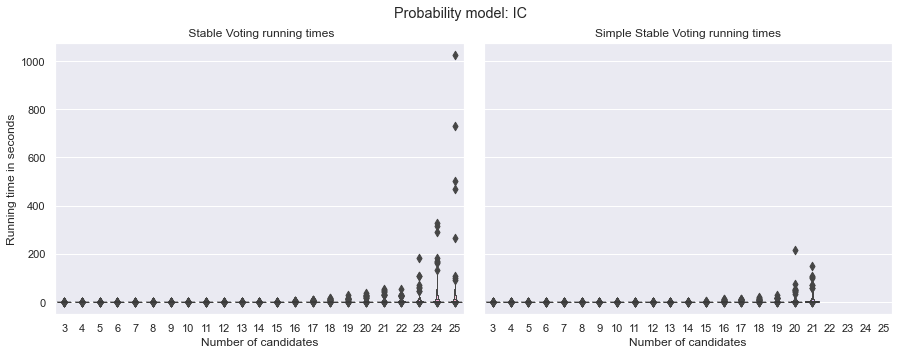

In [81]:
show_graph("IC")

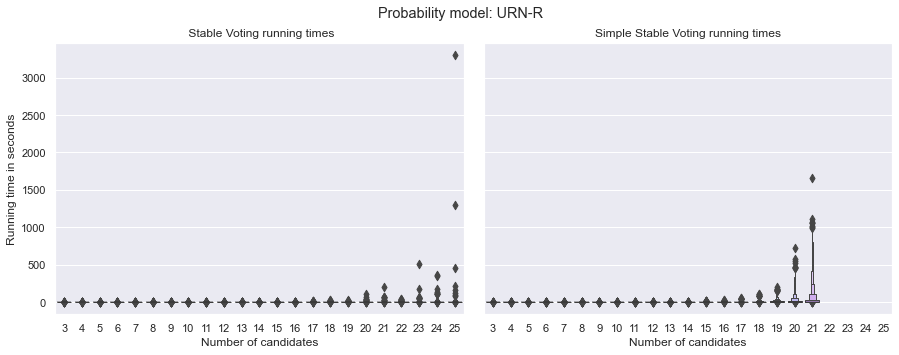

In [82]:
show_graph("URN-R")

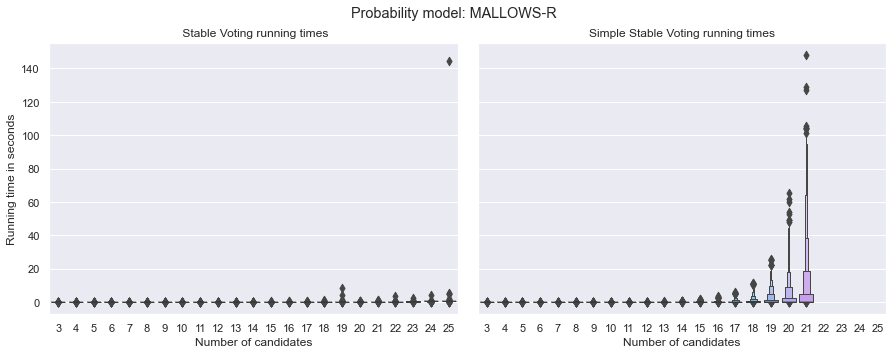

In [83]:
show_graph("MALLOWS-R")

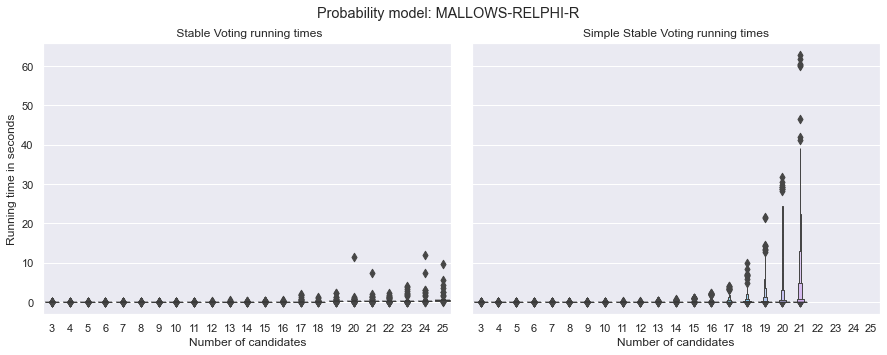

In [84]:
show_graph("MALLOWS-RELPHI-R")

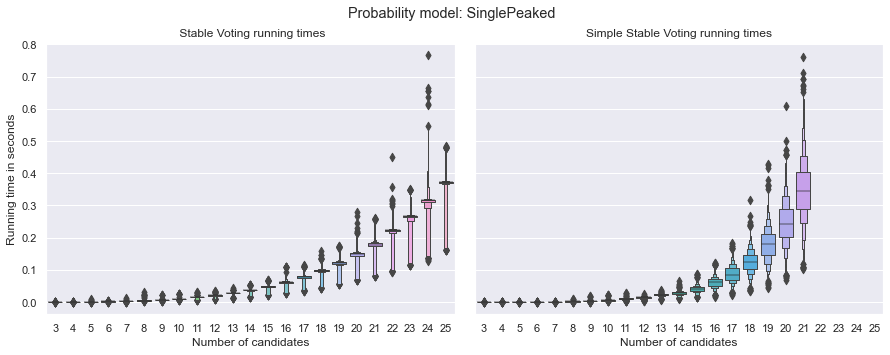

In [85]:
show_graph("SinglePeaked")